This notebook computes the infinite-width GP kernel for a Transformer.
The code runs as is, and we summarize the algorithm for computing the kernel in markdown cells, but the reader should take a look at the derivation in the paper to get the full picture.
We recommend the reader to have gone through [the RNN notebook](RNN.ipynb) first.

# Setup

In [1]:
import numpy as np
import scipy as sp
from numpy import asarray as npa
import numbers
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

Load the GloVe vectors and their covariances that we have saved.
They were generated from the two sentences

```The brown fox jumps over the dog.```

```The quick brown fox jumps over the lazy dog.```

Concretely, `exampleGloveVecs[:7]` contains the GloVe embeddings of the first sentence, and `exampleGloveVecs[7:16]` contains those of the second sentence.

Likewise, `exampleGloveCov` is a 16x16 matrix, such that `exampleGloveCov[:7, :7]` gives the autocovariance of the GloVe embeddings of the first sentence, `exampleGloveCov[7:, 7:]` gives that of the second sentence, and `exampleGloveCov[:7, 7:]` gives the covariance between those of the first and those of the second sentence.

In [2]:
sent1 = "The brown fox jumps over the dog".split()
sent2 = "The quick brown fox jumps over the lazy dog".split()

In [3]:
with open('ExampleGloVeVecs.npy', 'rb') as f:
    exampleGloveVecs = np.load(f)
with open('ExampleGloVeCov.npy', 'rb') as f:
    exampleGloveCov = np.load(f)

# Self-Attention / Transformers

We'll work with the following variant of the transformer model.
Let $x^0_1, \ldots, x^0_t$ be a sequence of inputs.
Then each layer $l$ of our transformer works like so
$$\begin{align*}
k^l_i &= U^l x_i^{l-1} \in \mathbb{R}^n\\
h^l_i &= \mathrm{Layernorm}(k^l_i + \mathrm{MaskedAttention}_i(k^l_i, \{k^l_j\}_{j=1}^t, \{k^l_j\}_{j=1}^t))\\
x^l_i &= \mathrm{Layernorm}(W^{l2}\mathrm{relu}(W^{l1}h^l_i + b^{l1})+ b^{l2} + h^l_i)
\end{align*}$$
where $U^l$, $W^{l1}, W^{l2}$ are weights and $b^{l1}, b^{l2}$ are the biases, and
$$\mathrm{MaskedAttention}_j(q, \{k^i\}_{i=1}^r, \{v^i\}_{i=1}^r)
= \sum_{i=1}^r a_i v^i, \qquad
a_i = \mathrm{SoftMax}(q^\top k^1/n, \ldots, q^\top k^j/n, -\infty, \ldots, -\infty)_i$$
for any $j \le r$.

There are several differences between this transformer and the standard version of [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762):

- We do not represent positional embedding explicitly; assume that they are already applied to $x^0_1, \ldots, x^0_t$.
- The keys, values, and queries here are the same, compared to the standard version, where they are different linear projections of $x^{l-1}_i$
- There is only 1 head, compared to the standard multi-head attention
- Our scaled attention is scaled by $n^{-1}$ instead of $n^{-1/2}$

The first three differences are just to simplify the presentation, but the last difference is fundamental.
As $n \to \infty$, $q^\top k/n$ will tend to a constant almost surely, but $q^\top k /\sqrt n$ will tend to either infinity (if $\lim_{n\to\infty} q^\top k/n \ne 0$) or a Gaussian variable (if $\lim_{n\to\infty} q^\top k/n = 0$).
In our case, since the keys and the queries are from the same collection, $q^\top k /n$ in general has a nonzero limit, so that $q^\top k /\sqrt n$ does not make sense here.


In code, this version of transformer looks like the following

In [4]:
# using torch only for inplace sampling of tensors
import torch as th

def relu(c):
    return c * (c > 0)
    
class Transformer():
    def __init__(self, d, d_in, depth, temp=1, vu=1, vw=1, vb=0):
        self.d = d
        self.depth = depth
        self.temp = temp
        self.vu = vu
        self.vw = vw
        self.vb = vb
        self.Us = [np.random.randn(d, d) * np.sqrt(vu/d) 
                   for _ in range(depth-1)]
        self.W1s = [np.random.randn(d, d) * np.sqrt(vw/d) 
                   for _ in range(depth)]
        self.b1s = [np.random.randn(d) * np.sqrt(vb)
                    for _ in range(depth)]
        self.W2s = [np.random.randn(d, d) * np.sqrt(vw/d) 
                   for _ in range(depth)]
        self.b2s = [np.random.randn(d) * np.sqrt(vb)
                    for _ in range(depth)]
        self.embedding = np.random.randn(d_in, d) * np.sqrt(vu/d_in)
        
    def __call__(self, seq):
        '''
        Input:
            seq: seqlen x tokensize array, for any seqlen and tokensize
        Output:
            out: seqlen x self.d_in array, for the same seqlen as input
        '''
        inseq = seq @ self.embedding
        for l in range(self.depth):
            if l > 0:
                inseq = inseq @ self.Us[l-1]
            # self attn
            gram = inseq @ inseq.T / inseq.shape[1]
            gram[np.triu_indices(gram.shape[0], 1)] = -np.inf
            weights = sp.special.softmax(gram / self.temp, axis=1)
            # weights @ inseq gives vectors returned by attention
            # inseq + weights @ inseq is the residual connection
            post_attn = self.layernorm(inseq + weights @ inseq)
            # self.post_attn = post_attn
            
            # FF
            inseq = relu(post_attn @ self.W1s[l] + self.b1s[l])
            inseq = inseq @ self.W2s[l] + self.b2s[l]
            inseq = inseq @ self.W2s[l] + self.b2s[l]
            inseq = self.layernorm(inseq + post_attn)
            
        return inseq
    def layernorm(self, seq):
        '''inplace layernorm
        Input:
            seq: seqlen x tokensize array, for any seqlen and tokensize
        Output:
            out: seqlen x tokensize array
                Means and standard deviation computed over the `tokensize` dimension
        '''
        seq -= np.mean(seq, axis=1, keepdims=True)
        seq /= np.std(seq, axis=1, keepdims=True)
        return seq
        
    def randomize(self, vu=None, vw=None, vb=None):
        if vu is None:
            vu = self.vu
        if vw is None:
            vw = self.vw
        if vb is None:
            vb = self.vb
        for p in self.W1s + self.W2s:
            # numpy has no way of sampling in place
            th.from_numpy(p).normal_(std=np.sqrt(vw / self.d))
        for p in self.b1s + self.b2s:
            th.from_numpy(p).normal_(std=np.sqrt(vb))
        for p in self.Us:
            th.from_numpy(p).normal_(std=np.sqrt(vu / self.d))

# Theoretical Kernel

For simplicity, assume for all $\alpha, \beta \in [n]$,

- $W^{l1}_{\alpha\beta}, W^{l2}_{\alpha\beta} \sim \mathcal{N}(0, \sigma_w^2/n)$ for all $l \ge 1$
- $U^l_{\alpha\beta} \sim \mathcal{N}(0, \sigma_u^2/n)$ for all $l \ge 2$ and $U^1_{\alpha\beta} \sim \mathcal{N}(0, \sigma_u^2/m)$
- $b^{l1}_\alpha, b^{l2}_\alpha \sim \mathcal{N}(0, \sigma_b^2)$ for all $l$

Suppose we have 2 input sequences $\{x_{11}, \ldots, x_{T_1 1} \in \mathbb R^m \}$ and $\{x_{12}, \ldots, x_{T_2 2} \in \mathbb R^m\}$ of lengths $T_1$ and $T_2$ respectively.

The transformer maps each sequence to another sequence of embeddings
$$y_{1a}, \ldots, y_{T_a a} = \mathrm{Transformer}(x_{1a}, \ldots, x_{T_a a}), a \in [2],$$
with each $y_{ia} \in \mathbb R^n$.
Our paper (in particular, the *NETSOR Master Theorem*) shows that the Gram matrix of $y_{ia}$s converge to a deterministic limit $K \in \mathbb R^{(T_1 + T_2) \times (T_1 + T_2)}$ as the width $n \to \infty$ and as the weights and biases are sampled as above.\
When combined with an independently sampled readout layer, this result shows that the infinite-width transformer is a GP at initialization with kernel $K$.

We may compute the matrix $K$ as follows (see paper for derivation):

- Initialize $\boldsymbol \Sigma^0 \in \mathbb R^{(T_1 + T_2) \times (T_1 + T_2)}$ by $\boldsymbol \Sigma^0 \gets \sigma_u^2 x_{ia}^\top x_{jb} / m$ for all $a, b \in [2]$ and $i \in [T_a], j \in [T_b]$.

- For $l = 1, \ldots, L$, do
    - Set $\Sigma^{l-1, 1} \gets \boldsymbol \Sigma^{l-1}_{1:T_1, 1:T_1}$ be the diagonal block corresponding to the 1st sequence, and set $\Sigma^{l-1, 2} \gets \boldsymbol \Sigma^{l-1}_{T_1+1:T_1+T_2, T_1+1:T_1+T_2}$ be the diagonal block corresponding to the 2nd sequence.
    - Set $\Delta^{la} \gets \mathrm{SoftMax}(\mathrm{Mask}(\Sigma^{l-1,a}))$ for each $a \in [2]$, where $\mathrm{Mask}$ replaces the upper triangular portion portion (above the diagonal) with $-\infty$, and $\mathrm{SoftMax}$ is applied to each row.
        - *This calculates the masked-attention weights.*
    - Set $\boldsymbol \Delta^l \gets \begin{pmatrix} \Delta^{l1} & 0 \\ 0 & \Delta^{l2} \end{pmatrix}$
    - Set $\hat {\boldsymbol \Sigma}^l \gets (I + \boldsymbol \Delta^l) \boldsymbol \Sigma^{l-1} (I + \boldsymbol \Delta^l)^\top$
        - *This computes the Gram matrix of post-(attention+residual) activations*
    - Set $\hat {\boldsymbol \Sigma}^l \gets D^{-1/2} \hat {\boldsymbol \Sigma}^l D^{-1/2}$, where $D = \mathrm{Diag}(\boldsymbol \Sigma^l)$
        - *Division by $D^{1/2}$ corresponds to applying layernorm*
    - Set $\boldsymbol \Sigma^l \gets \sigma_w^2 \mathrm{V}_{\mathrm{ReLU}}(\sigma_w^2 \hat{\boldsymbol \Sigma}^l + \sigma_b^2) + \sigma_b^2$
        - *Here $\mathrm{V}_{\mathrm{ReLU}}(\Sigma) = D^{1/2} J_1(D^{-1/2}\Sigma D^{-1/2}) D^{1/2}$ where $D = \mathrm{Diag}(\Sigma)$ and $J_1: [-1, 1] \to \mathbb R$ is defined as
            $$J_1(c) = \frac 1 \pi (\sqrt{1 - c^2} + (\pi - \arccos(c))c)$$
        - *and is applied entrywise.*
    - This corresponds to applying the perceptron
    - Set $\boldsymbol \Sigma^l \gets \sigma_u^2 D^{-1/2}(\boldsymbol \Sigma^l + \hat{\boldsymbol \Sigma}^l) D^{-1/2}$, where $D = \mathrm{Diag}(\boldsymbol \Sigma^l + \hat{\boldsymbol \Sigma}^l)$.
        - *The addition corresponds to skip connection*
        - *The division by $D^{1/2}$ corresponds to layernorm*
    
- Return $\frac 1 {\sigma_u^2} \boldsymbol \Sigma^L$

## Numpy Implementation

The following implements the above in `numpy`.

In [5]:
from utils import VReLU, getCor
def _trsfmr2(ingram, seq2idx, temp=1, vu=1, vw=1, vb=0):
    r'''Private method.
    Computes the kernel for a 1-layer single-head transformer
    running over 2 sequences
    Inputs:
        ingram: matrix.
            The gram matrix for the tokens of the two sequences
        seq2idx: the index such that
            `ingram[:seq2idx, :seq2idx]` is the gram matrix
             of the first sequence, and
             `ingram[seq2idx:, seq2idx:]` is the gram matrix
             of the second sequence.
        temp: temperature for softmax
        vu: variance of pre-attention weights
        vw: variance of MLP weights
        vb: variance of bias
    Outputs:
        the kernel of the same size as `ingram`
        of the output tokens of the transformer
    '''
    ingram = vu * ingram
    ingram1 = np.copy(ingram[:seq2idx, :seq2idx])
    ingram2 = np.copy(ingram[seq2idx:, seq2idx:])
    # masked presoftmax values
    ingram1[np.triu_indices(ingram1.shape[0], 1)] = -np.inf
    ingram2[np.triu_indices(ingram2.shape[0], 1)] = -np.inf
    # Gram matrix of the linear combination weights to be applied
    #   as the combination of attention and skip connection.
    # The identity matrix represents the skip connection.
    # The softmax part represents attention weights
    # Weights for sequence 1
    K1 = np.eye(ingram1.shape[0]) \
        + sp.special.softmax(ingram1 / temp, axis=1)
    # Weights for sequence 2
    K2 = np.eye(ingram2.shape[0]) \
        + sp.special.softmax(ingram2 / temp, axis=1)
    post_res_attn = np.zeros_like(ingram)
    post_res_attn[:seq2idx, :seq2idx] = K1 @ ingram[:seq2idx, :seq2idx] @ K1.T
    post_res_attn[seq2idx:, seq2idx:] = K2 @ ingram[seq2idx:, seq2idx:] @ K2.T
    post_res_attn[:seq2idx, seq2idx:] = K1 @ ingram[:seq2idx, seq2idx:] @ K2.T
    post_res_attn[seq2idx:, :seq2idx] = post_res_attn[:seq2idx, seq2idx:].T
    # do layernorm
    layer1 = getCor(post_res_attn)
    # do fc layers
    post_ffn = vw * VReLU(vw * layer1 + vb) + vb
    # do layernorm again
    layer2 = getCor(post_ffn + layer1)
    return {'layer1': layer1, 'layer2': layer2}

def th_trsfmr(ingram, seq2idx, depth, temp=1, vu=1, vw=1, vb=0):
    r'''
    Computes the kernel for a single-head transformer
    running over 2 sequences
    Inputs:
        ingram: matrix.
            The gram matrix for the tokens of the two sequences
        seq2idx: the index such that
            `ingram[:seq2idx, :seq2idx]` is the gram matrix
             of the first sequence, and
             `ingram[seq2idx:, seq2idx:]` is the gram matrix
             of the second sequence.
        depth: number of layers
        temp: temperature for softmax
        vu: variance of pre-attention weights
        vw: variance of MLP weights
        vb: variance of bias
    Outputs:
        the kernel of the same size as `ingram`
        of the output tokens of the transformer
    '''
    for l in range(depth):
        ingram = _trsfmr2(ingram, seq2idx,
                          temp=temp, vu=vu, vw=vw, vb=vb)['layer2']
    return ingram

If we apply this function to the kernel of the GloVe embeddings we loaded from file, then we get

In [6]:
depth = 2
vu = 2
vw = 3
vb = 0.1
theoryker = th_trsfmr(exampleGloveCov, 7, depth=depth, vu=vu, vw=vw, vb=vb)

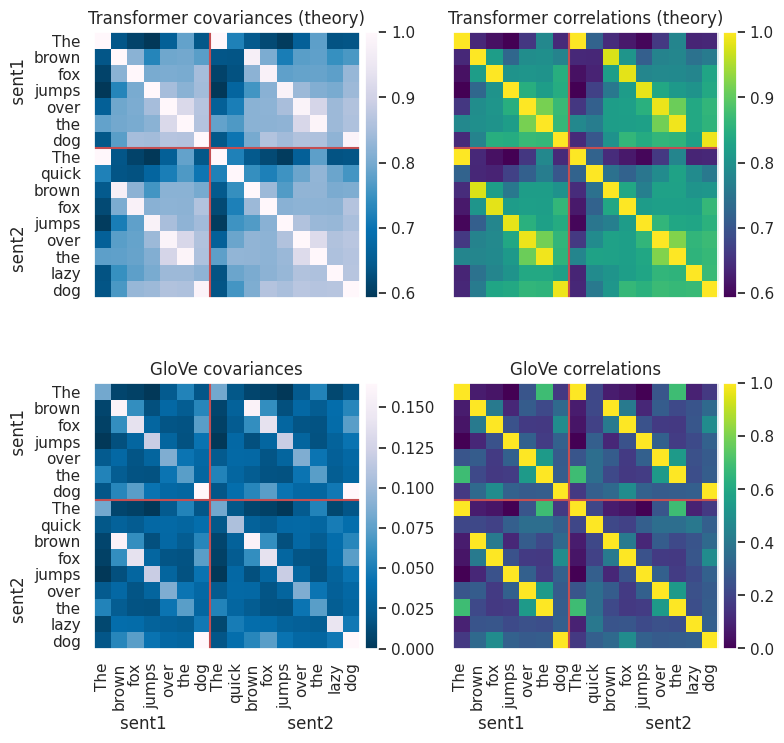

In [7]:
from utils import getCor, colorbar

plt.figure(figsize=(8, 8))

plt.subplot(221)
ax = plt.gca()
im_thcov = plt.imshow(theoryker, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks([])
plt.title('Transformer covariances (theory)')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_thcov)

plt.subplot(222)
ax = plt.gca()
im_thcor = plt.imshow(getCor(theoryker), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks([])
plt.title('Transformer correlations (theory)')
# plt.colorbar()
plt.grid()
colorbar(im_thcor)


plt.subplot(223)
ax = plt.gca()
im_glove = plt.imshow(exampleGloveCov, cmap='PuBu_r')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks(np.arange(16), sent1+sent2)
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe covariances')
plt.xlabel('sent1                       sent2')
plt.ylabel('sent2                       sent1')
plt.grid()
colorbar(im_glove)

plt.subplot(224)
ax = plt.gca()
im_glovecor = plt.imshow(getCor(exampleGloveCov), cmap='viridis')
span = np.linspace(-.5, 15.5)
plt.plot(span, [6.5]*len(span), 'r')
plt.plot([6.5]*len(span), span, 'r')
plt.yticks([])
plt.xticks(np.arange(16), sent1+sent2, rotation=90)
plt.title('GloVe correlations')
plt.xlabel('sent1                       sent2')
plt.grid()
colorbar(im_glovecor)

plt.tight_layout()

In [8]:
with open('transformer2layer.kernel', 'wb') as f:
    np.save(f, theoryker)

# Verify Theory with Simulations

We randomly initialize 100 transformers for each width among $[2^5, 2^6, \ldots, 2^{13}]$ and run them on the two sentences above.
We calculate the empirical Gram matrix of the transformer embeddings as well as its Frobenius distance to the infinite-width theoretical kernel `theoryker`.

In [9]:
widths = [2**i for i in range(5, 13)]
frobs = []
for d_h in widths:
    mytrfmr = Transformer(d_h, 300, depth=depth, vu=vu, vw=vw, vb=vb)
    for _ in range(10):
        mytrfmr.randomize()
        outvecs1 = mytrfmr(exampleGloveVecs[:7])
        outvecs2 = mytrfmr(exampleGloveVecs[7:])
        outvecs = np.concatenate([outvecs1, outvecs2])
        outgram = outvecs @ outvecs.T / outvecs.shape[1]
        diff = outgram - theoryker
        frobs.append({
            "absfrob": np.linalg.norm(diff)**2,
            "relfrob": (np.linalg.norm(diff) / np.linalg.norm(theoryker))**2,
            "width": d_h
        })

We store the results in a dataframe `frob_df`.

In [10]:
frob_df = pd.DataFrame(frobs)

In [11]:
frob_df.to_pickle('transformer2layer.df')

The deviation from infinite-width theory drops with width, as expected.

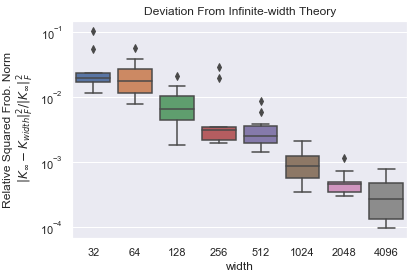

In [12]:
sns.boxplot(x='width', y='relfrob', data=frob_df)
plt.semilogy()
# plt.legend()
plt.title('Deviation From Infinite-width Theory')
_ = plt.ylabel(u'Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')

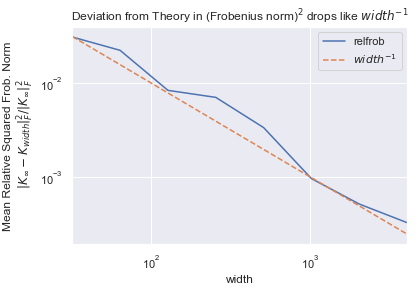

In [13]:
frob_df.groupby('width', as_index=False).mean().plot.line(x='width', y='relfrob')
plt.plot(widths, np.array(widths, dtype='float')**-1, '--', label=u'${width}^{-1}$')
plt.ylabel(u'Mean Relative Squared Frob. Norm\n $\|K_{\infty} - K_{width}\|_F^2/\|K_{\infty}\|_F^2$')
plt.loglog()
plt.legend()
_ = plt.title(u'Deviation from Theory in (Frobenius norm)$^2$ drops like $width^{-1}$')